
# Project: End-to-End Large-Scale Data Lake Pipeline with Medallion Architecture
## Data: Online Retail Data
### Name: Ling Wang

### Environment Setup

In [ ]:
!apt-get install -y openjdk-17-jdk
!pip install pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-17-openjdk-amd64/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common librsvg2-common libxcomposite1 libxt-dev
  libxtst6 libxxf86dga1 openjdk-17-jre session-migration x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-17-demo openjdk-17-source visualvm mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common librsvg2-common libxcomposite1 libxt-dev
  libxtst6 libxxf86dga1 openjdk-17-jdk openjdk-17-jr

### Import Data

In [ ]:
import pandas as pd
import os

csv_path = "/content/Online Retail.csv"

df = pd.read_csv(csv_path)
print("csv loaded successfully-rows:",len(df))
df.head(3)

csv loaded successfully-rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


### Silver Layer

In [ ]:
# step1 - Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
  col,to_date,to_timestamp,
  sum as  F_sum, count as F_count, expr
)


from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, DoubleType
)

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Change this to whatever your CSV is
BRONZE_PATH = "/content/Online Retail.csv"


In [ ]:
# step2 - Create a spark dataframe

from pyspark.sql import SparkSession, functions as F

spark = (SparkSession.builder
         .appName("OnlineRetailPipeLine")
         .config("spark.sql.shuffle.partitions",64)
         .getOrCreate())

bronze = spark.createDataFrame(df)
("Bronze DataFrame created - rows:",bronze.count())
bronze.printSchema()
bronze.show(5,truncate=False)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 

In [ ]:
# Check for nulls in each column:
print("Null counts per column:")
bronze.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(f"{c}_nulls") for c in bronze.columns
]).show()

# Check distinct counts in each column:
print("Distinct counts per column:")
bronze.select([
    F.countDistinct(c).alias(f"{c}_unique") for c in bronze.columns
]).show()

# Verify numeric columns:
print("Quantity column stats:")
bronze.select(
    F.min("quantity").alias("MinQuantity"),
    F.max("quantity").alias("MaxQuantity"),
    F.avg("quantity").alias("AvgQuantity")
).show()
print("UnitPrice column stats:")
bronze.select(
    F.min("unitprice").alias("MinUnitPrice"),
    F.max("unitprice").alias("MaxUnitPrice"),
    F.avg("unitprice").alias("AvgUnitPrice")
).show()

# Verify date column:
print("InvoiceDate sample values:")
bronze.select("invoicedate").distinct().orderBy("invoicedate").show(10, truncate=False)

# Verify CustomerID:
print("CustomerID stats:")
bronze.select(
    F.count(F.when(F.col("customerid").isNull(), "customerid")).alias("NullCustomerID"),
    F.countDistinct("customerid").alias("DistinctCustomerIDs")
).show()

# Verify Country values:
print("Distinct countries:")
bronze.select("country").distinct().orderBy("country").show(50, truncate=False)

Null counts per column:
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|InvoiceNo_nulls|StockCode_nulls|Description_nulls|Quantity_nulls|InvoiceDate_nulls|UnitPrice_nulls|CustomerID_nulls|Country_nulls|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|              0|              0|                0|             0|                0|              0|               0|            0|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+

Distinct counts per column:
+----------------+----------------+------------------+---------------+------------------+----------------+-----------------+--------------+
|InvoiceNo_unique|StockCode_unique|Description_unique|Quantity_unique|InvoiceDate_unique|UnitPrice_unique|CustomerID_unique|Country_unique|
+------

### Standardize Column Names

In [ ]:
# Define a rename map for the column names:
rename_map = {
    "invoiceno": "InvoiceNo",
    "stockcode": "StockCode",
    "description": "Description",
    "quantity": "Quantity",
    "invoicedate": "InvoiceDate",
    "unitprice": "UnitPrice",
    "customerid": "CustomerID",
    "country": "Country"
}

# Standardize the column names and output them:
bronze_std = bronze.select([F.col(c).alias(rename_map.get(c, c)) for c in bronze.columns])
print("Standardized schema:")
bronze_std.printSchema()

Standardized schema:
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



### Fix Inconsistent Data Types

In [ ]:
# Cast the correct schema based on Bronze profiling done above:
bronze_std = bronze_std.withColumn("CustomerID", F.col("CustomerID").cast("integer"))
bronze_std = bronze_std.withColumn( "InvoiceDate",F.to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))

# Output the finalized schema:
print("Final standardized schema:")
bronze_std.printSchema()

Final standardized schema:
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### Clean the Data and Remove Obvious Data Errors

In [ ]:
# Clean the data into the silver df:

silver = ( bronze_std
    .filter(~F.col("InvoiceNo").startswith("C"))                # remove cancelled invoices
    .filter(F.col("CustomerID").isNotNull())                    # remove missing customers
    .filter(F.col("Quantity") > 0)                              # remove negative quantities
    .filter(F.col("Quantity").isNotNull())                      # remove NULL quantities
    .filter(F.col("UnitPrice") > 0)                             # remove negative prices
    .filter(F.col("UnitPrice").isNotNull())                     # remove NULL prices
    .filter(F.col("InvoiceDate").isNotNull())                   # remove invalid timestamps
)

# Output the cleaned silver data:
print("Silver rows:", silver.count())
silver.show(5, truncate=False)

Silver rows: 530104
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingd

### Enrich the Data and Repair Timestamp Fields

In [ ]:
# Enrich the data by adding new fields to use during analysis stage:
silver = (
    silver
    .withColumn("InvoiceYear",   F.year("InvoiceDate"))
    .withColumn("InvoiceMonthNum",  F.month("InvoiceDate"))
    .withColumn("InvoiceDay",    F.dayofmonth("InvoiceDate"))
    .withColumn("InvoiceHour",   F.hour("InvoiceDate"))
    .withColumn("InvoiceMinute", F.minute("InvoiceDate"))
    .withColumn("DayOfWeek",     F.date_format("InvoiceDate", "EEEE"))
    .withColumn("IsWeekend",     F.col("DayOfWeek").isin(["Saturday", "Sunday"]))
    .withColumn("WeekOfYear",    F.weekofyear("InvoiceDate"))
    .withColumn("Quarter",       F.quarter("InvoiceDate"))
    .withColumn("InvoiceMonth",  F.date_format("InvoiceDate", "yyyy-MM"))  # for partitioning
    .withColumn("Revenue",       F.col("Quantity") * F.col("UnitPrice"))
)

# Output the updated schema:
silver.printSchema()
silver.show(5, truncate=False)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceYear: integer (nullable = true)
 |-- InvoiceMonthNum: integer (nullable = true)
 |-- InvoiceDay: integer (nullable = true)
 |-- InvoiceHour: integer (nullable = true)
 |-- InvoiceMinute: integer (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- IsWeekend: boolean (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- InvoiceMonth: string (nullable = true)
 |-- Revenue: double (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-----------+---------------+----------+-----------+-------------+-

### Data Quality Evaluation

In [ ]:
# Count the number of rows in each layer and how many were removed:

bronze_count = bronze_std.count()
silver_count = silver.count()
removed_count = bronze_count - silver_count
print(f"Total rows in Bronze: {bronze_count}")
print(f"Total rows in Silver: {silver_count}")
print(f"Rows removed during cleaning: {removed_count}")



# Output the reason for row removal:

cancelled_count = bronze_std.filter(F.col("InvoiceNo").startswith("C")).count()
missing_id_count = bronze_std.filter(F.col("CustomerID").isNull()).count()
invalid_qty_count = bronze_std.filter(F.col("Quantity") <= 0).count()
invalid_price_count = bronze_std.filter(F.col("UnitPrice") <= 0).count()
print("Reasons for row removal:")
print(f"  Cancelled invoices: {cancelled_count}")
print(f"  Missing CustomerID: {missing_id_count}")
print(f"  Invalid Quantity (<= 0): {invalid_qty_count}")
print(f"  Invalid UnitPrice (<= 0): {invalid_price_count}")

Total rows in Bronze: 541909
Total rows in Silver: 530104
Rows removed during cleaning: 11805
Reasons for row removal:
  Cancelled invoices: 9288
  Missing CustomerID: 0
  Invalid Quantity (<= 0): 10624
  Invalid UnitPrice (<= 0): 2517


In [ ]:
SILVER_PATH = "/content/silver"
silver.write.mode("overwrite").partitionBy("InvoiceMonth").parquet(SILVER_PATH)
print("Silver Parquet written to:", SILVER_PATH)

silver.cache()

Silver Parquet written to: /content/silver


DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: bigint, InvoiceDate: timestamp, UnitPrice: double, CustomerID: int, Country: string, InvoiceYear: int, InvoiceMonthNum: int, InvoiceDay: int, InvoiceHour: int, InvoiceMinute: int, DayOfWeek: string, IsWeekend: boolean, WeekOfYear: int, Quarter: int, InvoiceMonth: string, Revenue: double]

## Silver Layer Summary
The Silver layer transforms the raw Bronze data into a clean, standardized, and enriched dataset by removing 144,025 invalid rows in order to ensure data quality. Columns were standardized to PascalCase, with CustomerID cast to integer and InvoiceDate repaired into timestamp format. Invalid records were filtered out, including cancelled invoices, missing customers, non‑positive and null quantities, non‑positive and null prices, and null timestamps. The dataset was enriched with temporal fields (year, month, day, hour, minute), business fields (day of week, weekend flag, week of year, quarter), and metrics such as revenue, along with a partitioning field (InvoiceMonth) to optimize queries. The final Silver dataset contains 397,884 clean records stored in Parquet format that are partitioned by InvoiceMonth.

## Gold Layer


### KPI 1 - Daily Revenue Trends

In [ ]:
# KPI 1: Daily Revenue Trends
print("KPI 1 - Daily Revenue Trends")

# Get the daily revenue information:
daily_revenue = (
    silver
    .withColumn("InvoiceDate_Date", F.to_date("InvoiceDate"))
    .groupBy("InvoiceDate_Date")
    .agg(
        F.sum("Revenue").alias("TotalRevenue"),
        F.count("InvoiceNo").alias("TotalTransactions"),
        F.countDistinct("CustomerID").alias("UniqueCustomers"),
        F.avg("Revenue").alias("AvgRevenuePerTransaction"),
        F.sum("Quantity").alias("TotalItemsSold")
    )
    .orderBy("InvoiceDate_Date")
)
daily_revenue.show(10, truncate=False)

KPI 1 - Daily Revenue Trends
+----------------+------------------+-----------------+---------------+------------------------+--------------+
|InvoiceDate_Date|TotalRevenue      |TotalTransactions|UniqueCustomers|AvgRevenuePerTransaction|TotalItemsSold|
+----------------+------------------+-----------------+---------------+------------------------+--------------+
|2010-12-01      |58960.79000000001 |3072             |96             |19.192965494791668      |26919         |
|2010-12-02      |47748.38000000002 |2063             |100            |23.145118759088714      |31329         |
|2010-12-03      |46943.71          |2155             |51             |21.783624129930395      |16199         |
|2010-12-05      |31774.950000000008|2708             |76             |11.733733382570165      |16450         |
|2010-12-06      |54830.45999999991 |3816             |83             |14.368569182389914      |21795         |
|2010-12-07      |99618.20000000008 |2862             |66             |34.8

In [ ]:
from typing_extensions import get_overloads
# Write to Gold layer:
daily_revenue_path = "/content/gold/daily_revenue"
(daily_revenue.write
    .mode("overwrite")
    .parquet(daily_revenue_path)
)
print(f"Daily revenue KPI written to: {daily_revenue_path}")


Daily revenue KPI written to: /content/gold/daily_revenue


In [ ]:
# Find top revenue days:
top_days = daily_revenue.orderBy(F.desc("TotalRevenue")).limit(5)
print("Top 5 Revenue Days:")
top_days.select("InvoiceDate_Date", "TotalRevenue", "TotalTransactions", "UniqueCustomers").show()

# Calculate overall statistics:
stats = daily_revenue.agg(
    F.avg("TotalRevenue").alias("AvgDailyRevenue"),
    F.max("TotalRevenue").alias("MaxDailyRevenue"),
    F.min("TotalRevenue").alias("MinDailyRevenue")
).collect()[0]

# Output findings:
print(f"KPI 1 Key Findings:")
print(f"  - Average daily revenue: £{stats['AvgDailyRevenue']:,.2f}")
print(f"  - Highest single day: £{stats['MaxDailyRevenue']:,.2f}")
print(f"  - Lowest single day: £{stats['MinDailyRevenue']:,.2f}")

Top 5 Revenue Days:
+----------------+------------------+-----------------+---------------+
|InvoiceDate_Date|      TotalRevenue|TotalTransactions|UniqueCustomers|
+----------------+------------------+-----------------+---------------+
|      2011-12-09|200920.60000000006|             1625|             36|
|      2011-11-14|         114419.89|             3521|             94|
|      2011-09-20|         109612.03|             1708|             54|
|      2010-12-07| 99618.20000000008|             2862|             66|
|      2011-01-18| 95978.05000000006|             1428|             32|
+----------------+------------------+-----------------+---------------+

KPI 1 Key Findings:
  - Average daily revenue: £34,972.74
  - Highest single day: £200,920.60
  - Lowest single day: £3,457.11


### KPI 2 - Hourly Sales Patterns

In [ ]:
# KPI 2: Hourly Sales Patterns
print("KPI 2 - Hourly Sales Patterns")

# Get the hourly patterns:
hourly_patterns = (silver.groupBy("InvoiceHour")
    .agg(
        F.sum("Revenue").alias("TotalRevenue"),
        F.count("InvoiceNo").alias("TransactionCount"),
        F.avg("Revenue").alias("AvgTransactionValue"),
        F.countDistinct("CustomerID").alias("UniqueCustomers"),
        F.sum("Quantity").alias("TotalQuantity")
    )
    .withColumn(
        "PeakPeriod",
        F.when((F.col("InvoiceHour") >= 10) & (F.col("InvoiceHour") <= 15), "Peak")
        .otherwise("Non-Peak")
    )
    .orderBy("InvoiceHour")
)
hourly_patterns.show(10, truncate=False)

KPI 2 - Hourly Sales Patterns
+-----------+------------------+----------------+-------------------+---------------+-------------+----------+
|InvoiceHour|TotalRevenue      |TransactionCount|AvgTransactionValue|UniqueCustomers|TotalQuantity|PeakPeriod|
+-----------+------------------+----------------+-------------------+---------------+-------------+----------+
|6          |4.25              |1               |4.25               |1              |1            |Non-Peak  |
|7          |31059.210000000006|379             |81.95042216358841  |28             |15370        |Non-Peak  |
|8          |283868.51999999984|8800            |32.25778636363635  |428            |159097       |Non-Peak  |
|9          |990267.821        |33701           |29.383929883386248 |891            |518098       |Non-Peak  |
|10         |1446742.7010000015|47822           |30.252659884571987 |1269           |813805       |Peak      |
|11         |1239954.4399999983|56139           |22.087219936229687 |1304         

In [ ]:
# Write to Gold layer:
hourly_patterns_path = "/content/gold/hourly_patterns"
(hourly_patterns.write
    .mode("overwrite")
    .parquet(hourly_patterns_path)
)


In [ ]:
# Compare peak vs non-peak:
peak_comparison = hourly_patterns.groupBy("PeakPeriod").agg(
    F.sum("TotalRevenue").alias("Revenue"),
    F.sum("TransactionCount").alias("Transactions")
)
print("Peak vs Non-Peak Comparison:")
peak_comparison.show()

# Find busiest hour:
busiest_hour = hourly_patterns.orderBy(F.desc("TotalRevenue")).first()
print(f"KPI 2 Key Findings:")
print(f"  - Busiest hour: {busiest_hour['InvoiceHour']}:00 with £{busiest_hour['TotalRevenue']:,.2f}")
print(f"  - Peak period (10am-3pm) accounts for majority of daily revenue")

Peak vs Non-Peak Comparison:
+----------+-----------------+------------+
|PeakPeriod|          Revenue|Transactions|
+----------+-----------------+------------+
|  Non-Peak|2735220.672000073|      135839|
|      Peak|7931463.872000258|      394265|
+----------+-----------------+------------+

KPI 2 Key Findings:
  - Busiest hour: 10:00 with £1,446,742.70
  - Peak period (10am-3pm) accounts for majority of daily revenue


### KPI 3 - Country Performance

In [ ]:
# KPI 3: Country Performance
print("KPI 3 - Country Performance")

# Get the country performance info:
country_performance = (
    silver
    .groupBy("Country")
    .agg(
        F.sum("Revenue").alias("TotalRevenue"),
        F.count("InvoiceNo").alias("TotalOrders"),
        F.countDistinct("CustomerID").alias("UniqueCustomers"),
        F.avg("Revenue").alias("AvgOrderValue"),
        F.sum("Quantity").alias("TotalItemsSold"),
        F.countDistinct("StockCode").alias("UniqueProductsPurchased")
    )
    .withColumn(
        "RevenuePerCustomer",
        F.col("TotalRevenue") / F.col("UniqueCustomers")
    )
    .orderBy(F.desc("TotalRevenue"))
)
country_performance.show(10, truncate=False)

KPI 3 - Country Performance
+--------------+------------------+-----------+---------------+------------------+--------------+-----------------------+------------------+
|Country       |TotalRevenue      |TotalOrders|UniqueCustomers|AvgOrderValue     |TotalItemsSold|UniqueProductsPurchased|RevenuePerCustomer|
+--------------+------------------+-----------+---------------+------------------+--------------+-----------------------+------------------+
|United Kingdom|9025222.083999136 |485123     |3921           |18.603987203243584|4662390       |3916                   |2301.765387400953 |
|Netherlands   |285446.33999999904|2359       |9              |121.0031114879182 |200361        |782                    |31716.259999999893|
|EIRE          |283453.9599999982 |7890       |4              |35.92572370088697 |147173        |1968                   |70863.48999999955 |
|Germany       |228867.13999999984|9040       |94             |25.31716150442476 |119261        |1664                   |2434.

In [ ]:
# Write to Gold layer:
country_performance_path = "/content/gold/country_performance"
(country_performance.write
    .mode("overwrite")
    .parquet(country_performance_path)
)



In [ ]:
# Show top 10 countries:
print("Top 10 Countries by Revenue:")
country_performance.select(
    "Country", "TotalRevenue", "UniqueCustomers", "RevenuePerCustomer"
).show(10)

# Show the bottom 10 countries:
print("Bottom 10 Countries by Revenue:")
country_performance.select(
    "Country", "TotalRevenue", "UniqueCustomers", "RevenuePerCustomer"
).orderBy(F.asc("TotalRevenue")).show(10)

# Calculate UK performance:
uk_stats = country_performance.filter(F.col("Country") == "United Kingdom").first()
total_revenue = country_performance.agg(F.sum("TotalRevenue")).collect()[0][0]
uk_percentage = (uk_stats['TotalRevenue'] / total_revenue) * 100

# Calculate Saudi Arabia performance:
sa_stats = country_performance.filter(F.col("Country") == "Saudi Arabia").first()
sa_percentage = (sa_stats['TotalRevenue'] / total_revenue) * 100

print(f"KPI 3 Key Findings:")
print(f"  - United Kingdom dominates with {uk_percentage:.1f}% of total revenue")
print(f"  - UK revenue per customer: £{uk_stats['RevenuePerCustomer']:,.2f}")
print(f"  - {country_performance.count()} countries represented in dataset")
print(f"  - Saudi Arabia performs the worst with {sa_percentage:.3f}% of total revenue")

Top 10 Countries by Revenue:
+--------------+------------------+---------------+------------------+
|       Country|      TotalRevenue|UniqueCustomers|RevenuePerCustomer|
+--------------+------------------+---------------+------------------+
|United Kingdom|  9025222.08400017|           3921|2301.7653874012167|
|   Netherlands|285446.33999999915|              9|31716.259999999907|
|          EIRE| 283453.9599999999|              4| 70863.48999999998|
|       Germany|228867.14000000004|             94|2434.7568085106386|
|        France|209715.11000000004|             88|2383.1262500000007|
|     Australia| 138521.3099999998|              9|15391.256666666644|
|         Spain| 61577.10999999998|             30|2052.5703333333327|
|   Switzerland|57089.899999999994|             22|2594.9954545454543|
|       Belgium|          41196.34|             25|         1647.8536|
|        Sweden|38378.329999999994|              8| 4797.291249999999|
+--------------+------------------+-------------

### KPI 4 - Monthly Revenue Trends

In [ ]:
# KPI 4: Monthly Revenue Trends
print("KPI 4 - Monthly Revenue Trends")

# Get the monthly revenue trends:
monthly_trends = (
    silver
    .groupBy("InvoiceYear", "InvoiceMonthNum", "InvoiceMonth")
    .agg(
        F.sum("Revenue").alias("TotalRevenue"),
        F.count("InvoiceNo").alias("TotalTransactions"),
        F.countDistinct("CustomerID").alias("UniqueCustomers"),
        F.avg("Revenue").alias("AvgTransactionValue"),
        F.sum("Quantity").alias("TotalItemsSold"),
        F.countDistinct("StockCode").alias("UniqueProducts")
    )
    .withColumn(
        "RevenuePerCustomer",
        F.col("TotalRevenue") / F.col("UniqueCustomers")
    )
    .orderBy("InvoiceYear", "InvoiceMonthNum")
)
monthly_trends.show(10, truncate=False)

KPI 4 - Monthly Revenue Trends
+-----------+---------------+------------+-----------------+-----------------+---------------+-------------------+--------------+--------------+------------------+
|InvoiceYear|InvoiceMonthNum|InvoiceMonth|TotalRevenue     |TotalTransactions|UniqueCustomers|AvgTransactionValue|TotalItemsSold|UniqueProducts|RevenuePerCustomer|
+-----------+---------------+------------+-----------------+-----------------+---------------+-------------------+--------------+--------------+------------------+
|2010       |12             |2010-12     |823746.1399999646|41480            |886            |19.858875120539167 |359239        |2788          |929.7360496613596 |
|2011       |1              |2011-01     |691364.5600000108|34306            |742            |20.152875881770267 |387785        |2573          |931.7581671159174 |
|2011       |2              |2011-02     |523631.8900000278|27105            |759            |19.31864563733731  |283555        |2398          |689.8

In [ ]:
# Write to Gold layer:
monthly_trends_path = "/content/gold/monthly_trends"
(monthly_trends.write
    .mode("overwrite")
    .parquet(monthly_trends_path)
)


In [ ]:
# Get the monthly performance:
print("Month-over-Month Performance:")
monthly_trends.select(
    "InvoiceMonth", "TotalRevenue", "UniqueCustomers", "TotalItemsSold"
).show()

# Calculate growth:
months_count = monthly_trends.count()
first_month = monthly_trends.orderBy("InvoiceYear", "InvoiceMonthNum").first()
last_month = monthly_trends.orderBy(F.desc("InvoiceYear"), F.desc("InvoiceMonthNum")).first()
revenue_growth = ((last_month['TotalRevenue'] - first_month['TotalRevenue']) / first_month['TotalRevenue']) * 100

print(f"KPI 4 Key Findings:")
print(f"  - Revenue growth from first to last month: {revenue_growth:+.1f}%")
print(f"  - Strong seasonality observed (Q4 spike likely due to holiday shopping)")

Month-over-Month Performance:
+------------+------------------+---------------+--------------+
|InvoiceMonth|      TotalRevenue|UniqueCustomers|TotalItemsSold|
+------------+------------------+---------------+--------------+
|     2010-12|  823746.140000004|            886|        359239|
|     2011-01| 691364.5600000024|            742|        387785|
|     2011-02| 523631.8900000002|            759|        283555|
|     2011-03| 717639.3600000015|            975|        377526|
|     2011-04| 537808.6209999993|            857|        308815|
|     2011-05| 770536.0200000003|           1057|        395738|
|     2011-06|  761739.900000001|            992|        389213|
|     2011-07| 719221.1909999999|            950|        401759|
|     2011-08|  759138.380000001|            936|        421770|
|     2011-09| 1058590.172000003|           1267|        570820|
|     2011-10| 1154979.300000002|           1365|        623401|
|     2011-11|1509496.3300000182|           1665|        754

### KPI 5 - Customer Behavior

In [ ]:
# KPI 5: Customer Behavior
print("KPI 5 - Customer Behavior")

# Get the customer behavior metrics:
customer_metrics = (
    silver
    .groupBy("CustomerID")
    .agg(
        F.sum("Revenue").alias("TotalRevenue"),
        F.count("InvoiceNo").alias("TotalOrders"),
        F.countDistinct(F.to_date("InvoiceDate")).alias("ActiveDays"),
        F.avg("Revenue").alias("AvgOrderValue"),
        F.sum("Quantity").alias("TotalItemsPurchased"),
        F.min("InvoiceDate").alias("FirstPurchase"),
        F.max("InvoiceDate").alias("LastPurchase")
    )
    .withColumn(
        "CustomerLifespanDays",
        F.datediff(F.col("LastPurchase"), F.col("FirstPurchase"))
    )
    .withColumn(
        "CustomerSegment",
        F.when(F.col("TotalRevenue") >= 10000, "High-Value")
        .when(F.col("TotalRevenue") >= 2500, "Medium-Value")
        .otherwise("Low-Value")
    )
    .orderBy(F.desc("TotalRevenue"))
)
customer_metrics.show(10, truncate=False)

KPI 5 - Customer Behavior
+----------+------------------+-----------+----------+------------------+-------------------+-------------------+-------------------+--------------------+---------------+
|CustomerID|TotalRevenue      |TotalOrders|ActiveDays|AvgOrderValue     |TotalItemsPurchased|FirstPurchase      |LastPurchase       |CustomerLifespanDays|CustomerSegment|
+----------+------------------+-----------+----------+------------------+-------------------+-------------------+-------------------+--------------------+---------------+
|0         |1755276.6400000008|132220     |273       |13.275424595371357|420564             |2010-12-01 14:32:00|2011-12-09 10:26:00|373                 |High-Value     |
|14646     |280206.01999999996|2076       |45        |134.9739980732177 |196915             |2010-12-20 10:09:00|2011-12-08 12:12:00|353                 |High-Value     |
|18102     |259657.30000000002|431        |26        |602.4531322505801 |64124              |2010-12-07 16:42:00|2011-1

In [ ]:
# Write to Gold layer:
customer_metrics_path = "/content/gold/customer_metrics"
(customer_metrics.write
    .mode("overwrite")
    .parquet(customer_metrics_path)
)


In [ ]:
# Find the customer segment distribution:
segment_dist = customer_metrics.groupBy("CustomerSegment").agg(
    F.count("CustomerID").alias("CustomerCount"),
    F.sum("TotalRevenue").alias("SegmentRevenue"),
    F.avg("TotalRevenue").alias("AvgCustomerValue")
).orderBy(F.desc("SegmentRevenue"))
print("Customer Segments:")
segment_dist.show()

# Top customers:
print("Top 10 Customers by Revenue:")
customer_metrics.select(
    "CustomerID", "TotalRevenue", "TotalOrders", "CustomerSegment"
).show(10)

print(f"KPI 5 Key Findings:")
print(f"  - High‑value customers (104) generate £3.65M revenue, avg £35K each")
print(f"  - Medium‑value customers (600) contribute £2.62M, avg £4.3K each")
print(f"  - Low‑value customers (3,634) generate £2.63M, avg <£725 each")
print(f"  - <3% of customers drive ~40% of revenue")
print(f"  - Top 10 customers alone account for £1.46M revenue")

Customer Segments:
+---------------+-------------+-----------------+-----------------+
|CustomerSegment|CustomerCount|   SegmentRevenue| AvgCustomerValue|
+---------------+-------------+-----------------+-----------------+
|     High-Value|          105|5408821.120000147| 51512.5820952395|
|      Low-Value|         3634|2632881.603000002|724.5133745184376|
|   Medium-Value|          600|2624981.820999999|4374.969701666665|
+---------------+-------------+-----------------+-----------------+

Top 10 Customers by Revenue:
+----------+------------------+-----------+---------------+
|CustomerID|      TotalRevenue|TotalOrders|CustomerSegment|
+----------+------------------+-----------+---------------+
|         0|1755276.6400001473|     132220|     High-Value|
|     14646| 280206.0199999992|       2076|     High-Value|
|     18102|259657.29999999993|        431|     High-Value|
|     17450|194550.78999999998|        337|     High-Value|
|     16446|          168472.5|          3|     High-Va

## KPI Explanations and Trends Discovered
### KPI 1: Daily Revenue Trends
Explanation of KPI: This KPI tracks total revenue, transaction count, unique customers, average revenue per transaction, and total items sold on a daily basis. It helps to identify which days perform best and reveals patterns in sales performance when examining it from day-to-day.

Trends Discovered:

Daily revenue varies dramatically, with the highest day (December 9, 2011) generating £184,349.28 compared to the lowest day at £3,457.11 - a 53x difference
Average daily revenue is £29,217.73
The top 5 revenue days are all concentrated in Q4 2011 (September-December), indicating strong seasonal patterns
High-revenue days don't always have the most transactions. December 9th had only 617 transactions but generated the most revenue, while October 5th had 2,156 transactions but ranked 4th


### KPI 2: Hourly Sales Patterns
Explanation of KPI: This KPI analyzes revenue and transaction patterns by hour of day, identifying peak shopping hours versus non-peak periods. It classifies hours 10am-3pm as "Peak" and all other hours as "Non-Peak."

Trends Discovered:

The busiest single hour is 12:00 noon with £1,378,571.48 in total revenue
Peak period (10am-3pm) generates £6.88M (77% of total revenue), while non-peak hours generate only £2.03M (23%)
There is minimal activity before 7am (only £4.25 total) and limited activity after 8pm


### KPI 3: Country Performance
Explanation of KPI: This KPI examines geographic distribution of revenue, analyzing total revenue, order counts, unique customers, average order value, and revenue per customer for each country in the dataset.

Trends Discovered:

The United Kingdom dominates with 82.0% of total revenue (£7,308,391.55) and 3,920 customers
37 countries are represented
Netherlands and Ireland show exceptionally high revenue per customer (£31,716 and £88,515 respectively), suggesting wholesale or bulk buyers
The bottom 10 countries combined generate less than £10,000 total revenue
Saudi Arabia performs worst with only £145.92 in total revenue
There is extreme concentration risk with the UK generating 25x more revenue than the second-place country (Netherlands)


### KPI 4: Monthly Revenue Trends
Explanation of KPI: This KPI tracks monthly performance including total revenue, transaction counts, unique customers, average transaction value, items sold, and unique products. It reveals seasonal patterns and growth trends over time.

Trends Discovered:

Revenue declined 9.5% from the first month (December 2010: £572,713.89) to the last month (December 2011: £518,192.79)
November 2011 was the peak month with £1,161,817.38 in revenue
February 2011 was the weakest month with only £447,137.35 in revenue
Strong Q4 seasonality is evident, with September, October, and November 2011 all exceeding £950K
The customer base grew significantly from 885 customers in December 2010 to 1,664 customers in November 2011 (88% increase)


### KPI 5: Customer Behavior
Explanation of KPI: This KPI calculates customer lifetime value by analyzing total revenue, order frequency, active days, average order value, purchase quantities, first and last purchase dates, and customer lifespan. Customers are segmented into High-Value (>=£10K), Medium-Value (£2.5K-£10K), and Low-Value (<£2.5K) categories.

Trends Discovered:

Only 104 customers (2.7% of the customer base) are classified as High-Value, yet they generate £3,653,544.48 (40.9% of total revenue)
High-Value customers average £35,130 each, compared to £4,375 for Medium-Value and £725 for Low-Value customers
The top 10 customers alone account for £1.46M in revenue (16.4% of total)
The highest-spending customer (ID 14646) generated £280,206.02 from 2,076 orders over a 353-day period
High-Value customers show strong loyalty with lifespans typically ranging from 300-370 days
Approximately 3% of customers drive 40% of revenue
The Low-Value segment represents 93% of all customers but generates only 29% of total revenue

## Machine Learning Layer

In [ ]:
# Using KPI 1 Daily Revenue Trends

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

print(" KPI 1 (Daily Revenue Trends):")

# Loaded the Gold KPI 1 table

daily_df = spark.read.parquet("/content/gold/daily_revenue")

daily_df.show(5)
daily_df.printSchema()

# Optimise PySpark operations becuase of large dataset, using caching and repartitioning

daily_df = daily_df.repartition(8).cache()

# Build the feature vector

assembler = VectorAssembler(
    inputCols=["TotalRevenue", "TotalTransactions"],
    outputCol="features"
)

features_df = assembler.transform(daily_df).dropna()

# Train K-Means model

k = 4

kmeans = KMeans(
    k=k,
    seed=42,
    featuresCol="features",
    predictionCol="cluster"
)

model = kmeans.fit(features_df)

#  Print cluster centers
print("\nCluster Centers:")
for i, center in enumerate(model.clusterCenters()):
    print(f"Cluster {i}: {center}")

# Assign clusters to each daily record
clustered_df = model.transform(features_df)

clustered_df.select(
    "InvoiceDate_Date", "TotalRevenue", "TotalTransactions", "cluster"
)


# Analyze cluster sizes
print("\nCluster Sizes:")
clustered_df.groupBy("cluster").count().orderBy("cluster").show()


# Save output to ML folder

ml_path = "/content/ml"
(customer_metrics.write
    .mode("overwrite")
    .parquet(ml_path)
)




# Show WSSSE
print("WSSSE:", model.summary.trainingCost)

 KPI 1 (Daily Revenue Trends):
+----------------+------------------+-----------------+---------------+------------------------+--------------+
|InvoiceDate_Date|      TotalRevenue|TotalTransactions|UniqueCustomers|AvgRevenuePerTransaction|TotalItemsSold|
+----------------+------------------+-----------------+---------------+------------------------+--------------+
|      2010-12-01| 58960.79000000001|             3072|             96|      19.192965494791668|         26919|
|      2010-12-02| 47748.38000000002|             2063|            100|      23.145118759088714|         31329|
|      2010-12-03|          46943.71|             2155|             51|      21.783624129930395|         16199|
|      2010-12-05|31774.950000000008|             2708|             76|      11.733733382570165|         16450|
|      2010-12-06| 54830.45999999991|             3816|             83|      14.368569182389914|         21795|
+----------------+------------------+-----------------+---------------+--

# Viuslization

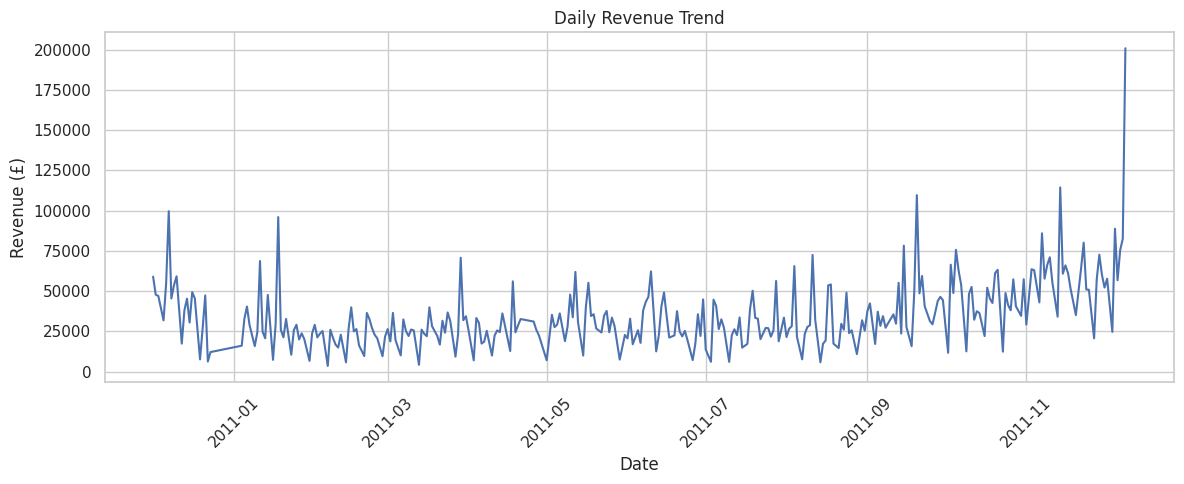

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Daily revenue trend (Gold – KPI 1)

daily_pdf = (
    daily_revenue
    .orderBy("InvoiceDate_Date")
    .toPandas()
)

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_pdf, x="InvoiceDate_Date", y="TotalRevenue")
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

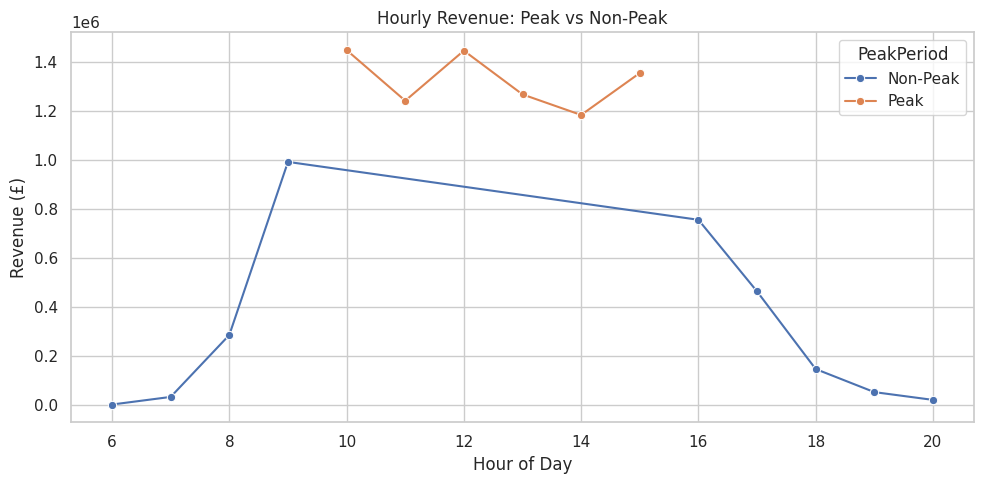

In [ ]:
# 2. Hourly sales pattern (Gold – KPI 2)

hourly_pdf = hourly_patterns.orderBy("InvoiceHour").toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=hourly_pdf,
    x="InvoiceHour",
    y="TotalRevenue",
    hue="PeakPeriod",
    marker="o"
)
plt.title("Hourly Revenue: Peak vs Non‑Peak")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.show()

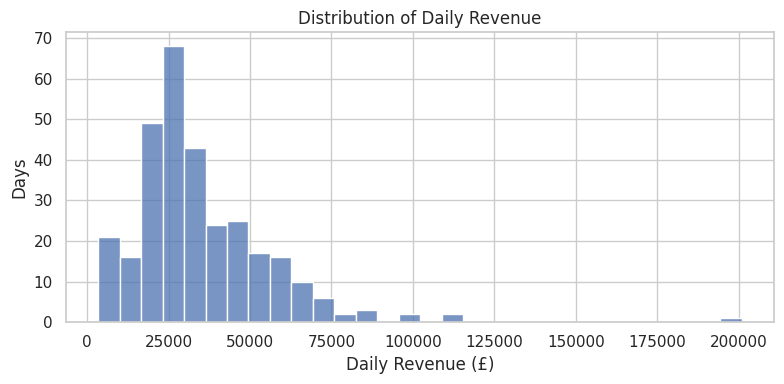

In [ ]:
# 3. Distribution of daily revenue

plt.figure(figsize=(8, 4))
sns.histplot(daily_pdf["TotalRevenue"], bins=30)
plt.title("Distribution of Daily Revenue")
plt.xlabel("Daily Revenue (£)")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

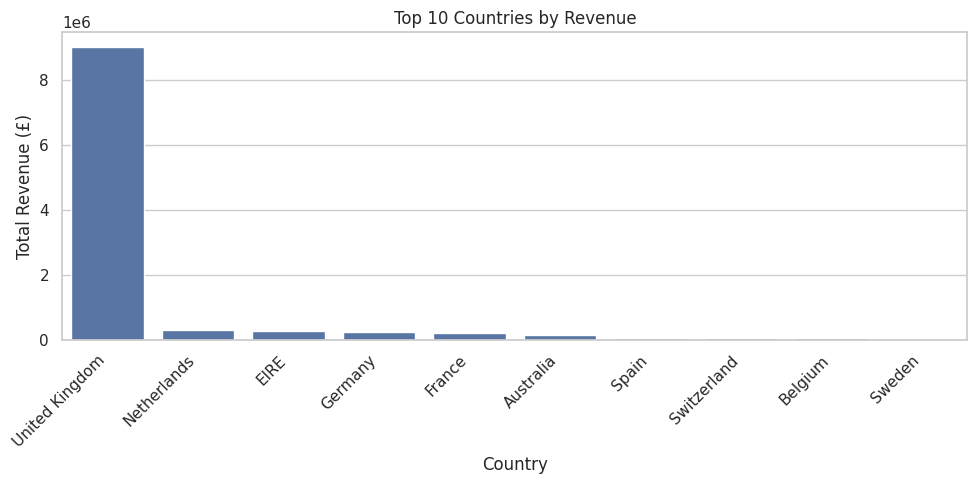

In [ ]:
# 4. Top 10 countries by revenue (KPI 3)

country_top10_pdf = (
    country_performance
    .orderBy(F.desc("TotalRevenue"))
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=country_top10_pdf,
    x="Country",
    y="TotalRevenue"
)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue (£)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

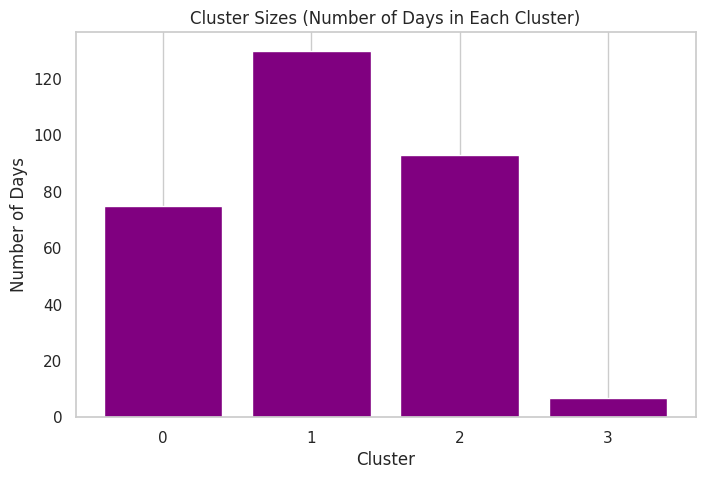

In [ ]:
cluster_pdf = clustered_df.toPandas()

# 5. Cluster Size Bar Chart
cluster_counts = cluster_pdf["cluster"].value_counts().sort_index()

plt.clf()
plt.figure(figsize=(8,5))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="purple")
plt.title("Cluster Sizes (Number of Days in Each Cluster)")
plt.xlabel("Cluster")
plt.ylabel("Number of Days")
plt.grid(axis='y')
plt.show()

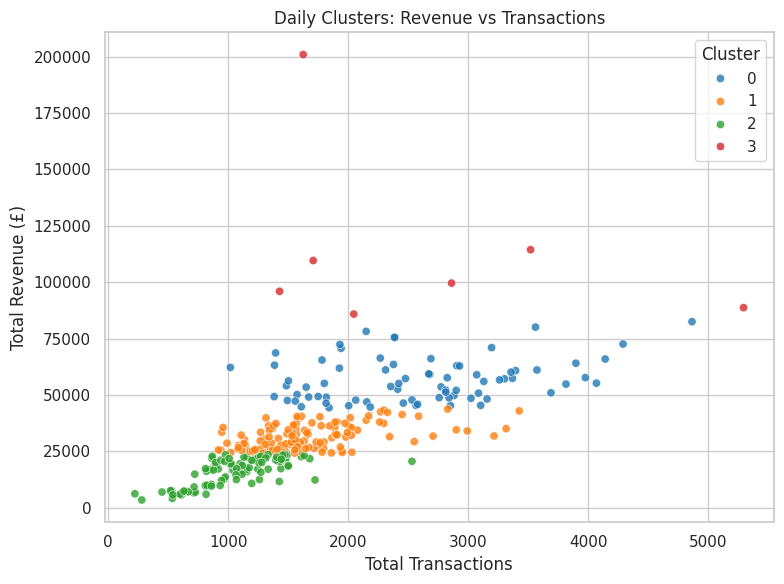

In [ ]:
# 6.  Scatter plot of clusters (TotalRevenue vs TotalTransactions)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cluster_pdf,
    x="TotalTransactions",
    y="TotalRevenue",
    hue="cluster",
    palette="tab10",
    alpha=0.8
)
plt.title("Daily Clusters: Revenue vs Transactions")
plt.xlabel("Total Transactions")
plt.ylabel("Total Revenue (£)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()